### **Import Library**

In [151]:
import time
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

#set warning
import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns', None)

In [152]:
filename = '../database/dataClean.csv'
df = pd.read_csv(filename, encoding = 'latin-1')
df

,label,tweet_clean
0,1,siapa calon presiden wakil presiden
1,1,seperti sinyal dukung bapak prabowo makin kuat...
2,1,keren banget bapak prabowo damping sama pangli...
3,1,penting ekonomi nasional aman amp lancar bu ap...
4,1,sri mulyani pilih dorong aktivitas ekonomi baik
...,...,...
995,0,mau sistem buka at tutup sama wong jurdil alia...
996,0,jelas sekali kodok bau siap curang main kasar ...
997,0,kakitangan rezim yaa begini laku percaya pilih...
998,0,rektor bodoh emang anis truk kuat nanjak ganja...


### **Visualizing Word Clouds**

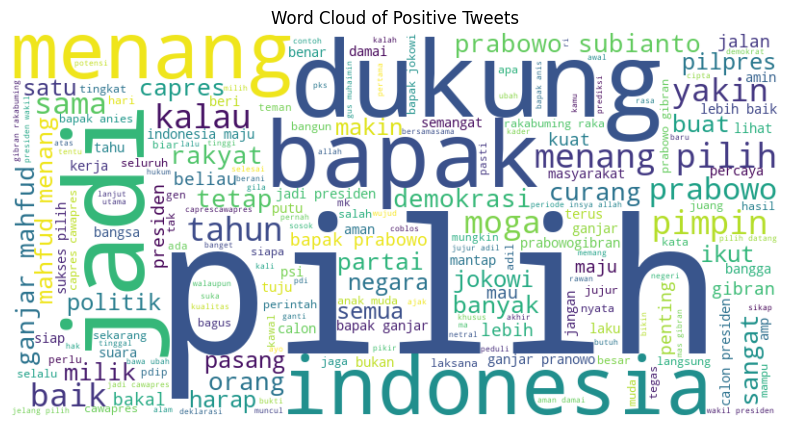

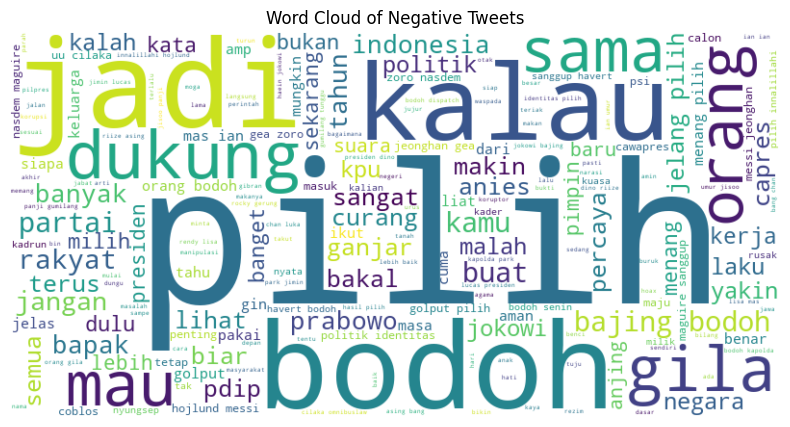

In [153]:
# Pisahkan tweet positif dan negatif
positive_tweets_text = ' '.join(df[df['label'] == 1]['tweet_clean'])
negative_tweets_text = ' '.join(df[df['label'] == 0]['tweet_clean'])

# Buat objek WordCloud untuk tweet positif
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets_text)

# Plot WordCloud untuk tweet positif
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Tweets')
plt.show()

# Buat objek WordCloud untuk tweet negatif
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets_text)

# Plot WordCloud untuk tweet negatif
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Tweets')
plt.show()

### **Split Data**

In [154]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet_clean'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

print("Data latih:")
print(y_train.value_counts())
print("\nData Uji:")
print(y_test.value_counts())

Data latih:
label
1    400
0    400
Name: count, dtype: int64

Data Uji:
label
1    100
0    100
Name: count, dtype: int64


### **Feature Extraction**

In [155]:
def compute_tfidf(X_train, X_test):
    # Inisialisasi TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 2)

    # Hitung TF-IDF pada data latih
    tfidf_train = tfidf_vectorizer.fit_transform(X_train)

    # Hitung TF-IDF pada data uji
    tfidf_test = tfidf_vectorizer.transform(X_test)

    # Kembalikan matriks TF-IDF
    return tfidf_train, tfidf_test

In [156]:
tfidf_train, tfidf_test = compute_tfidf(X_train, X_test)

# Cetak informasi matriks
print("Shape matriks TF-IDF data latih:", tfidf_train.shape)
print("Shape matriks TF-IDF data uji:", tfidf_test.shape)

Shape matriks TF-IDF data latih: (800, 1231)
Shape matriks TF-IDF data uji: (200, 1231)


### **Support Vector Machine Without Feature Selection** 

In [157]:
class SVMGridSearch:
    def __init__(self, kernel='linear', param_grid=None, tfidf_train=None, y_train=None, tfidf_test=None, y_test=None):
        self.kernel = kernel
        self.param_grid = param_grid
        self.tfidf_train = tfidf_train
        self.y_train = y_train
        self.tfidf_test = tfidf_test
        self.y_test = y_test

    def run_grid_search(self):
        if self.param_grid is None:
            raise ValueError("Parameter grid is not defined.")
        
        start_time_grid_search = time.time()
        if self.kernel == 'linear':
            grid_search = GridSearchCV(SVC(kernel=self.kernel), self.param_grid, cv=5)
        elif self.kernel == 'rbf' or self.kernel == 'poly':
            grid_search = GridSearchCV(SVC(kernel=self.kernel, gamma='scale'), self.param_grid, cv=5)
        else:
            raise ValueError("Invalid kernel type. Supported kernels are 'linear', 'rbf', and 'poly'.")
            
        grid_search.fit(self.tfidf_train, self.y_train)
        elapsed_time_grid_search = time.time() - start_time_grid_search
        print("Best Parameters:", grid_search.best_params_)
        return grid_search

    def evaluate_models(self, grid_search):
        results_data = {'C': [], 'Gamma': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': [], 'Time (s)': []}
        for params in grid_search.cv_results_['params']:
            start_time = time.time()
            clf = SVC(kernel=self.kernel, **params)
            clf.fit(self.tfidf_train, self.y_train)
            elapsed_time = time.time() - start_time
            accuracy = clf.score(self.tfidf_test, self.y_test)
            y_pred = clf.predict(self.tfidf_test)
            precision = precision_score(self.y_test, y_pred)
            recall = recall_score(self.y_test, y_pred)
            f1_score_value = f1_score(self.y_test, y_pred)
            results_data['C'].append(params.get('C', None))
            if 'gamma' in params:
                results_data['Gamma'].append(params['gamma'])
            else:
                results_data['Gamma'].append(None)
            results_data['Accuracy'].append(f'{accuracy:.3f}')
            results_data['Precision'].append(f'{precision:.3f}')
            results_data['Recall'].append(f'{recall:.3f}')
            results_data['F1-Score'].append(f'{f1_score_value:.3f}')
            results_data['Time (s)'].append(f'{elapsed_time:.2f}')
        results_df = pd.DataFrame(results_data)
        return results_df

# Define parameter grids outside the class
param_grid_linear = {
    'C': [0.1, 1, 10]
}

param_grid_non_linear = {
    'C': [0.1, 1, 10],
    'gamma': [0.5, 1, 2]
}

In [158]:
svm_grid_search_linear = SVMGridSearch(kernel='linear', param_grid=param_grid_linear, tfidf_train=tfidf_train, y_train=y_train, tfidf_test=tfidf_test, y_test=y_test)
grid_search_result_linear = svm_grid_search_linear.run_grid_search()
evaluation_results_linear = svm_grid_search_linear.evaluate_models(grid_search_result_linear)
print("Results for Linear Kernel:")
results_df_linear = pd.DataFrame(evaluation_results_linear)
results_df_linear

Best Parameters: {'C': 10}
Results for Linear Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,None,0.845,0.888,0.790,0.836,0.07
1,1.0,None,0.865,0.869,0.860,0.864,0.03
2,10.0,None,0.840,0.840,0.840,0.840,0.06


In [159]:
svm_grid_search_rbf = SVMGridSearch(kernel='rbf', param_grid=param_grid_non_linear, tfidf_train=tfidf_train, y_train=y_train, tfidf_test=tfidf_test, y_test=y_test)
grid_search_result_rbf = svm_grid_search_rbf.run_grid_search()
evaluation_results_rbf = svm_grid_search_rbf.evaluate_models(grid_search_result_rbf)
print("Results for RBF Kernel:")
results_df_rbf = pd.DataFrame(evaluation_results_rbf)
results_df_rbf

Best Parameters: {'C': 10, 'gamma': 0.5}
Results for RBF Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,0.5,0.765,0.688,0.970,0.805,0.06
1,0.1,1.0,0.785,0.708,0.970,0.819,0.06
2,0.1,2.0,0.620,0.568,1.000,0.725,0.07
3,1.0,0.5,0.860,0.860,0.860,0.860,0.06
4,1.0,1.0,0.855,0.859,0.850,0.854,0.06
5,1.0,2.0,0.880,0.888,0.870,0.879,0.07
6,10.0,0.5,0.860,0.860,0.860,0.860,0.06
7,10.0,1.0,0.865,0.869,0.860,0.864,0.06
8,10.0,2.0,0.875,0.887,0.860,0.873,0.06


In [160]:
svm_grid_search_poly = SVMGridSearch(kernel='poly', param_grid=param_grid_non_linear, tfidf_train=tfidf_train, y_train=y_train, tfidf_test=tfidf_test, y_test=y_test)
grid_search_result_poly = svm_grid_search_poly.run_grid_search()
evaluation_results_poly = svm_grid_search_poly.evaluate_models(grid_search_result_poly)
print("Results for Polynomial Kernel:")
results_df_poly = pd.DataFrame(evaluation_results_poly)
results_df_poly

Best Parameters: {'C': 10, 'gamma': 0.5}
Results for Polynomial Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,0.5,0.565,0.535,1.000,0.697,0.08
1,0.1,1.0,0.565,0.535,1.000,0.697,0.07
2,0.1,2.0,0.745,0.669,0.970,0.792,0.06
3,1.0,0.5,0.565,0.535,1.000,0.697,0.07
4,1.0,1.0,0.845,0.817,0.890,0.852,0.08
5,1.0,2.0,0.825,0.783,0.900,0.837,0.06
6,10.0,0.5,0.835,0.819,0.860,0.839,0.06
7,10.0,1.0,0.795,0.744,0.900,0.814,0.07
8,10.0,2.0,0.650,0.590,0.980,0.737,0.06


### **Support Vector Machine With Feature Selection** 

#### **Mutual Information Feature Selection**

In [161]:
class FeatureSelector:
    def __init__(self, percentile=90):
        self.percentile = percentile
        self.selector = SelectPercentile(score_func=mutual_info_classif, percentile=self.percentile)

    def fit_transform(self, X, y):
        X_selected = self.selector.fit_transform(X, y)
        return X_selected

    def transform(self, X):
        X_selected = self.selector.transform(X)
        return X_selected

    def get_support(self):
        return self.selector.get_support()

##### **Feature Selection 40 %**

In [162]:
# Inisialisasi objek FeatureSelector dengan percentile 40
feature_selector = SelectPercentile(percentile=40)

# Melakukan seleksi fitur pada data train
FS_train_40 = feature_selector.fit_transform(tfidf_train, y_train)

# Melakukan seleksi fitur pada data test
FS_test_40 = feature_selector.transform(tfidf_test)

# Dapatkan masker untuk fitur yang dipilih
feature_mask = feature_selector.get_support()

# Cetak hasil seleksi pada data train
print("Original Shape (Train):", tfidf_train.shape)
print("Shape after Feature Selection (Train):", FS_train_40.shape)

# Cetak hasil seleksi pada data test
print("Original Shape (Test):", tfidf_test.shape)
print("Shape after Feature Selection (Test):", FS_test_40.shape)

Original Shape (Train): (800, 1231)
Shape after Feature Selection (Train): (800, 492)
Original Shape (Test): (200, 1231)
Shape after Feature Selection (Test): (200, 492)


In [163]:
svm_grid_search_linear = SVMGridSearch(kernel='linear', param_grid=param_grid_linear, tfidf_train=FS_train_40, y_train=y_train, tfidf_test=FS_test_40, y_test=y_test)
grid_search_result_linear = svm_grid_search_linear.run_grid_search()
evaluation_results_linear = svm_grid_search_linear.evaluate_models(grid_search_result_linear)
print("Results for Linear Kernel:")
results_df_linear_40 = pd.DataFrame(evaluation_results_linear)
results_df_linear_40

Best Parameters: {'C': 1}
Results for Linear Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,None,0.830,0.893,0.750,0.815,0.03
1,1.0,None,0.885,0.881,0.890,0.886,0.02
2,10.0,None,0.875,0.871,0.880,0.876,0.02


In [164]:
svm_grid_search_rbf = SVMGridSearch(kernel='rbf', param_grid=param_grid_non_linear, tfidf_train=FS_train_40, y_train=y_train, tfidf_test=FS_test_40, y_test=y_test)
grid_search_result_rbf = svm_grid_search_rbf.run_grid_search()
evaluation_results_rbf = svm_grid_search_rbf.evaluate_models(grid_search_result_rbf)
print("Results for RBF Kernel:")
results_df_rbf_40 = pd.DataFrame(evaluation_results_rbf)
results_df_rbf_40

Best Parameters: {'C': 1, 'gamma': 2}
Results for RBF Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,0.5,0.840,0.840,0.840,0.840,0.04
1,0.1,1.0,0.860,0.840,0.890,0.864,0.04
2,0.1,2.0,0.855,0.851,0.860,0.856,0.04
3,1.0,0.5,0.885,0.874,0.900,0.887,0.03
4,1.0,1.0,0.885,0.881,0.890,0.886,0.05
5,1.0,2.0,0.885,0.874,0.900,0.887,0.04
6,10.0,0.5,0.880,0.896,0.860,0.878,0.02
7,10.0,1.0,0.880,0.880,0.880,0.880,0.02
8,10.0,2.0,0.870,0.863,0.880,0.871,0.03


In [165]:
svm_grid_search_poly = SVMGridSearch(kernel='poly', param_grid=param_grid_non_linear, tfidf_train=FS_train_40, y_train=y_train, tfidf_test=FS_test_40, y_test=y_test)
grid_search_result_poly = svm_grid_search_poly.run_grid_search()
evaluation_results_poly = svm_grid_search_poly.evaluate_models(grid_search_result_poly)
print("Results for Polynomial Kernel:")
results_df_poly_40 = pd.DataFrame(evaluation_results_poly)
results_df_poly_40

Best Parameters: {'C': 10, 'gamma': 1}
Results for Polynomial Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,0.5,0.555,0.529,1.000,0.692,0.04
1,0.1,1.0,0.555,0.529,1.000,0.692,0.03
2,0.1,2.0,0.595,0.553,0.990,0.710,0.03
3,1.0,0.5,0.555,0.529,1.000,0.692,0.04
4,1.0,1.0,0.600,0.556,0.990,0.712,0.03
5,1.0,2.0,0.830,0.884,0.760,0.817,0.03
6,10.0,0.5,0.650,0.590,0.980,0.737,0.02
7,10.0,1.0,0.840,0.895,0.770,0.828,0.03
8,10.0,2.0,0.870,0.870,0.870,0.870,0.04


##### **Feature Selection 60 %**

In [166]:
# Inisialisasi objek FeatureSelector dengan percentile 60
feature_selector = SelectPercentile(percentile=60)

# Melakukan seleksi fitur pada data train
FS_train_60 = feature_selector.fit_transform(tfidf_train, y_train)

# Melakukan seleksi fitur pada data test
FS_test_60 = feature_selector.transform(tfidf_test)

# Dapatkan masker untuk fitur yang dipilih
feature_mask = feature_selector.get_support()

# Cetak hasil seleksi pada data train
print("Original Shape (Train):", tfidf_train.shape)
print("Shape after Feature Selection (Train):", FS_train_60.shape)

# Cetak hasil seleksi pada data test
print("Original Shape (Test):", tfidf_test.shape)
print("Shape after Feature Selection (Test):", FS_test_60.shape)

Original Shape (Train): (800, 1231)
Shape after Feature Selection (Train): (800, 738)
Original Shape (Test): (200, 1231)
Shape after Feature Selection (Test): (200, 738)


In [167]:
svm_grid_search_linear = SVMGridSearch(kernel='linear', param_grid=param_grid_linear, tfidf_train=FS_train_60, y_train=y_train, tfidf_test=FS_test_60, y_test=y_test)
grid_search_result_linear = svm_grid_search_linear.run_grid_search()
evaluation_results_linear = svm_grid_search_linear.evaluate_models(grid_search_result_linear)
print("Results for Linear Kernel:")
results_df_linear_60 = pd.DataFrame(evaluation_results_linear)
results_df_linear_60

Best Parameters: {'C': 1}
Results for Linear Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,None,0.830,0.893,0.750,0.815,0.03
1,1.0,None,0.870,0.870,0.870,0.870,0.03
2,10.0,None,0.890,0.898,0.880,0.889,0.03


In [168]:
svm_grid_search_rbf = SVMGridSearch(kernel='rbf', param_grid=param_grid_non_linear, tfidf_train=FS_train_60, y_train=y_train, tfidf_test=FS_test_60, y_test=y_test)
grid_search_result_rbf = svm_grid_search_rbf.run_grid_search()
evaluation_results_rbf = svm_grid_search_rbf.evaluate_models(grid_search_result_rbf)
print("Results for RBF Kernel:")
results_df_rbf_60 = pd.DataFrame(evaluation_results_rbf)
results_df_rbf_60

Best Parameters: {'C': 1, 'gamma': 2}
Results for RBF Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,0.5,0.835,0.838,0.830,0.834,0.04
1,0.1,1.0,0.820,0.840,0.790,0.814,0.05
2,0.1,2.0,0.780,0.868,0.660,0.750,0.04
3,1.0,0.5,0.885,0.889,0.880,0.884,0.03
4,1.0,1.0,0.885,0.897,0.870,0.883,0.03
5,1.0,2.0,0.885,0.897,0.870,0.883,0.05
6,10.0,0.5,0.900,0.908,0.890,0.899,0.03
7,10.0,1.0,0.865,0.869,0.860,0.864,0.04
8,10.0,2.0,0.880,0.904,0.850,0.876,0.03


In [169]:
svm_grid_search_poly = SVMGridSearch(kernel='poly', param_grid=param_grid_non_linear, tfidf_train=FS_train_60, y_train=y_train, tfidf_test=FS_test_60, y_test=y_test)
grid_search_result_poly = svm_grid_search_poly.run_grid_search()
evaluation_results_poly = svm_grid_search_poly.evaluate_models(grid_search_result_poly)
print("Results for Polynomial Kernel:")
results_df_poly_60 = pd.DataFrame(evaluation_results_poly)
results_df_poly_60

Best Parameters: {'C': 1, 'gamma': 2}
Results for Polynomial Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,0.5,0.555,0.529,1.000,0.692,0.04
1,0.1,1.0,0.555,0.529,1.000,0.692,0.04
2,0.1,2.0,0.620,0.569,0.990,0.723,0.04
3,1.0,0.5,0.555,0.529,1.000,0.692,0.04
4,1.0,1.0,0.635,0.579,0.990,0.731,0.04
5,1.0,2.0,0.830,0.795,0.890,0.840,0.04
6,10.0,0.5,0.690,0.622,0.970,0.758,0.03
7,10.0,1.0,0.810,0.763,0.900,0.826,0.04
8,10.0,2.0,0.760,0.688,0.950,0.798,0.04


##### **Feature Selection 80 %**

In [170]:
# Inisialisasi objek FeatureSelector dengan percentile 80
feature_selector = SelectPercentile(percentile=80)

# Melakukan seleksi fitur pada data train
FS_train_80 = feature_selector.fit_transform(tfidf_train, y_train)

# Melakukan seleksi fitur pada data test
FS_test_80 = feature_selector.transform(tfidf_test)

# Dapatkan masker untuk fitur yang dipilih
feature_mask = feature_selector.get_support()

# Cetak hasil seleksi pada data train
print("Original Shape (Train):", tfidf_train.shape)
print("Shape after Feature Selection (Train):", FS_train_80.shape)

# Cetak hasil seleksi pada data test
print("Original Shape (Test):", tfidf_test.shape)
print("Shape after Feature Selection (Test):", FS_test_80.shape)

Original Shape (Train): (800, 1231)
Shape after Feature Selection (Train): (800, 984)
Original Shape (Test): (200, 1231)
Shape after Feature Selection (Test): (200, 984)


In [171]:
svm_grid_search_linear = SVMGridSearch(kernel='linear', param_grid=param_grid_linear, tfidf_train=FS_train_80, y_train=y_train, tfidf_test=FS_test_80, y_test=y_test)
grid_search_result_linear = svm_grid_search_linear.run_grid_search()
evaluation_results_linear = svm_grid_search_linear.evaluate_models(grid_search_result_linear)
print("Results for Linear Kernel:")
results_df_linear_80 = pd.DataFrame(evaluation_results_linear)
results_df_linear_80

Best Parameters: {'C': 1}
Results for Linear Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,None,0.830,0.884,0.760,0.817,0.05
1,1.0,None,0.860,0.853,0.870,0.861,0.04
2,10.0,None,0.840,0.840,0.840,0.840,0.03


In [172]:
svm_grid_search_rbf = SVMGridSearch(kernel='rbf', param_grid=param_grid_non_linear, tfidf_train=FS_train_80, y_train=y_train, tfidf_test=FS_test_80, y_test=y_test)
grid_search_result_rbf = svm_grid_search_rbf.run_grid_search()
evaluation_results_rbf = svm_grid_search_rbf.evaluate_models(grid_search_result_rbf)
print("Results for RBF Kernel:")
results_df_rbf_80 = pd.DataFrame(evaluation_results_rbf)
results_df_rbf_80

Best Parameters: {'C': 10, 'gamma': 0.5}
Results for RBF Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,0.5,0.805,0.729,0.970,0.833,0.08
1,0.1,1.0,0.835,0.796,0.900,0.845,0.07
2,0.1,2.0,0.820,0.771,0.910,0.835,0.08
3,1.0,0.5,0.865,0.876,0.850,0.863,0.04
4,1.0,1.0,0.870,0.885,0.850,0.867,0.05
5,1.0,2.0,0.860,0.883,0.830,0.856,0.06
6,10.0,0.5,0.855,0.866,0.840,0.853,0.06
7,10.0,1.0,0.875,0.887,0.860,0.873,0.06
8,10.0,2.0,0.870,0.894,0.840,0.866,0.06


In [173]:
svm_grid_search_poly = SVMGridSearch(kernel='poly', param_grid=param_grid_non_linear, tfidf_train=FS_train_80, y_train=y_train, tfidf_test=FS_test_80, y_test=y_test)
grid_search_result_poly = svm_grid_search_poly.run_grid_search()
evaluation_results_poly = svm_grid_search_poly.evaluate_models(grid_search_result_poly)
print("Results for Polynomial Kernel:")
results_df_poly_80 = pd.DataFrame(evaluation_results_poly)
results_df_poly_80

Best Parameters: {'C': 1, 'gamma': 2}
Results for Polynomial Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,0.5,0.555,0.529,1.000,0.692,0.06
1,0.1,1.0,0.555,0.529,1.000,0.692,0.06
2,0.1,2.0,0.715,0.641,0.980,0.775,0.06
3,1.0,0.5,0.555,0.529,1.000,0.692,0.06
4,1.0,1.0,0.755,0.681,0.960,0.797,0.06
5,1.0,2.0,0.835,0.807,0.880,0.842,0.06
6,10.0,0.5,0.790,0.730,0.920,0.814,0.06
7,10.0,1.0,0.800,0.754,0.890,0.817,0.05
8,10.0,2.0,0.720,0.645,0.980,0.778,0.06


##### **Feature Selection 90 %**

In [174]:
# Inisialisasi objek FeatureSelector dengan percentile 90
feature_selector = SelectPercentile(percentile=90)

# Melakukan seleksi fitur pada data train
FS_train_90 = feature_selector.fit_transform(tfidf_train, y_train)

# Melakukan seleksi fitur pada data test
FS_test_90 = feature_selector.transform(tfidf_test)

# Dapatkan masker untuk fitur yang dipilih
feature_mask = feature_selector.get_support()

# Cetak hasil seleksi pada data train
print("Original Shape (Train):", tfidf_train.shape)
print("Shape after Feature Selection (Train):", FS_train_90.shape)

# Cetak hasil seleksi pada data test
print("Original Shape (Test):", tfidf_test.shape)
print("Shape after Feature Selection (Test):", FS_test_90.shape)

Original Shape (Train): (800, 1231)
Shape after Feature Selection (Train): (800, 1107)
Original Shape (Test): (200, 1231)
Shape after Feature Selection (Test): (200, 1107)


In [175]:
svm_grid_search_linear = SVMGridSearch(kernel='linear', param_grid=param_grid_linear, tfidf_train=FS_train_90, y_train=y_train, tfidf_test=FS_test_90, y_test=y_test)
grid_search_result_linear = svm_grid_search_linear.run_grid_search()
evaluation_results_linear = svm_grid_search_linear.evaluate_models(grid_search_result_linear)
print("Results for Linear Kernel:")
results_df_linear_90 = pd.DataFrame(evaluation_results_linear)
results_df_linear_90

Best Parameters: {'C': 1}
Results for Linear Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,None,0.830,0.875,0.770,0.819,0.06
1,1.0,None,0.870,0.870,0.870,0.870,0.05
2,10.0,None,0.845,0.842,0.850,0.846,0.06


In [176]:
svm_grid_search_rbf = SVMGridSearch(kernel='rbf', param_grid=param_grid_non_linear, tfidf_train=FS_train_90, y_train=y_train, tfidf_test=FS_test_90, y_test=y_test)
grid_search_result_rbf = svm_grid_search_rbf.run_grid_search()
evaluation_results_rbf = svm_grid_search_rbf.evaluate_models(grid_search_result_rbf)
print("Results for RBF Kernel:")
results_df_rbf_90 = pd.DataFrame(evaluation_results_rbf)
results_df_rbf_90

Best Parameters: {'C': 10, 'gamma': 1}
Results for RBF Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,0.5,0.770,0.693,0.970,0.808,0.07
1,0.1,1.0,0.825,0.760,0.950,0.844,0.06
2,0.1,2.0,0.795,0.722,0.960,0.824,0.07
3,1.0,0.5,0.860,0.867,0.850,0.859,0.05
4,1.0,1.0,0.860,0.875,0.840,0.857,0.06
5,1.0,2.0,0.870,0.885,0.850,0.867,0.07
6,10.0,0.5,0.865,0.884,0.840,0.862,0.06
7,10.0,1.0,0.860,0.883,0.830,0.856,0.06
8,10.0,2.0,0.860,0.875,0.840,0.857,0.06


In [177]:
svm_grid_search_poly = SVMGridSearch(kernel='poly', param_grid=param_grid_non_linear, tfidf_train=FS_train_90, y_train=y_train, tfidf_test=FS_test_90, y_test=y_test)
grid_search_result_poly = svm_grid_search_poly.run_grid_search()
evaluation_results_poly = svm_grid_search_poly.evaluate_models(grid_search_result_poly)
print("Results for Polynomial Kernel:")
results_df_poly_90 = pd.DataFrame(evaluation_results_poly)
results_df_poly_90

Best Parameters: {'C': 10, 'gamma': 0.5}
Results for Polynomial Kernel:


,C,Gamma,Accuracy,Precision,Recall,F1-Score,Time (s)
0,0.1,0.5,0.565,0.535,1.000,0.697,0.06
1,0.1,1.0,0.565,0.535,1.000,0.697,0.06
2,0.1,2.0,0.740,0.664,0.970,0.789,0.06
3,1.0,0.5,0.565,0.535,1.000,0.697,0.06
4,1.0,1.0,0.805,0.748,0.920,0.825,0.07
5,1.0,2.0,0.825,0.788,0.890,0.836,0.06
6,10.0,0.5,0.840,0.809,0.890,0.848,0.06
7,10.0,1.0,0.810,0.767,0.890,0.824,0.06
8,10.0,2.0,0.670,0.605,0.980,0.748,0.06
